### (1) Data description

We work with two connected data sets: `players.csv` (one row per player) and `sessions.csv` (one row per play session). `players.csv` has 196 players and 7 variables. `sessions.csv` has 1,535 sessions. Both the tables use `hashedEmail` as an anonymous player ID so we can join.

**players.csv (one row per player)**

- `hashedEmail`: text ID, one per player  
- `subscribe`: TRUE/FALSE, if the player signed up for the newsletter  
- `Age`: numeric, age in years (mean ≈ 21.14, 2 missing)  
- `gender`: categorical, self-reported  
- `name`: text, first name  
- `experience`: categorical (Beginner, Amateur, Regular, Veteran, Pro)  
- `played_hours`: numeric, total hours played (mean ≈ 5.85)  

**sessions.csv (one row per session)**

- `hashedEmail`: text ID, links session to player  
- `start_time`, `end_time`: text time stamps (`DD/MM/YYYY HH:MM`)  
- `original_start_time`, `original_end_time`: numeric server time stamps  

From `sessions.csv` we create:

- `session_minutes`: length of each session in minutes  
- Per player: `total_playtime_min` (sum of session_minutes),  
  `avg_session_min` (mean session length),  
  `session_count` (number of sessions)

From 6 April–26 September 2024 there are 125 players with at least one session and 71 players with no sessions.

**Issues we can see**

- Missing values (age and some end times) and a few sessions with NA or zero duration  
- Strong skew in playtime (a few players play a lot more than others)  
- Possible mismatch between text times and server times  

**Possible hidden issues**

- Selection bias: only players who join this server appear in the data  
- Shared or automated accounts  
- Other factors (device, location, motivation) are not recorded but may affect play

Player information and newsletter sign-ups were collected through sign-up forms, while the session times were logged automatically by the game server and linked using `hashedEmail`.


### (2) Questions

**Broad question (Question1)**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?

**Specific question**  
Can player engagement behaviours like total play time, average session length, and session frequency predict whether a player subscribes to the game-related newsletter?

To answer this, we will:

- Use `sessions.csv` to build three engagements for each player:  
  `total_playtime_min`, `avg_session_min`, and `session_count`  
- Join these measures to `players.csv` by `hashedEmail` so that we only have one tidy row per player  
- Use `subscribe` as the response (TRUE/FALSE) and the engagement and the profile variables as predictors
- Remove sessions with missing or zero duration and represent the missing players age using either the median or a model.


### (3) Exploratory data analysis and visualization

We will load `players.csv` and `sessions.csv` into R, do the least amount of wrangling needed to make the data tidy, and then explore the main variables.

Steps:

- Read both CSV files and check their structure  
- Parse `start_time` and `end_time` to real date-time values  
- Compute `session_minutes` for each session and then summarise per player  
- Join the session summaries to `players.csv` so each row is one player  

For `players.csv` we will compute the mean of every numeric variable and show the results in a small table, with values rounded to 2 decimals.

For graphs, we will:

- Plot a histogram of `Age`  
- Plot a histogram of `played_hours`  
- Make a boxplot of `total_playtime_min` by `experience`  
- Make a bar chart of mean `total_playtime_min` by `subscribe`  

These plots help us see how age and experience are spread in the sample, how skewed playtime is, and if the newsletter subscribers seem to play more and have more sessions than non-subscribers. Before modeling, we will scale the numeric predictors (total_playtime_min and avg_session_min) and use one-hot encoding for categorical variables like gender and experience.


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


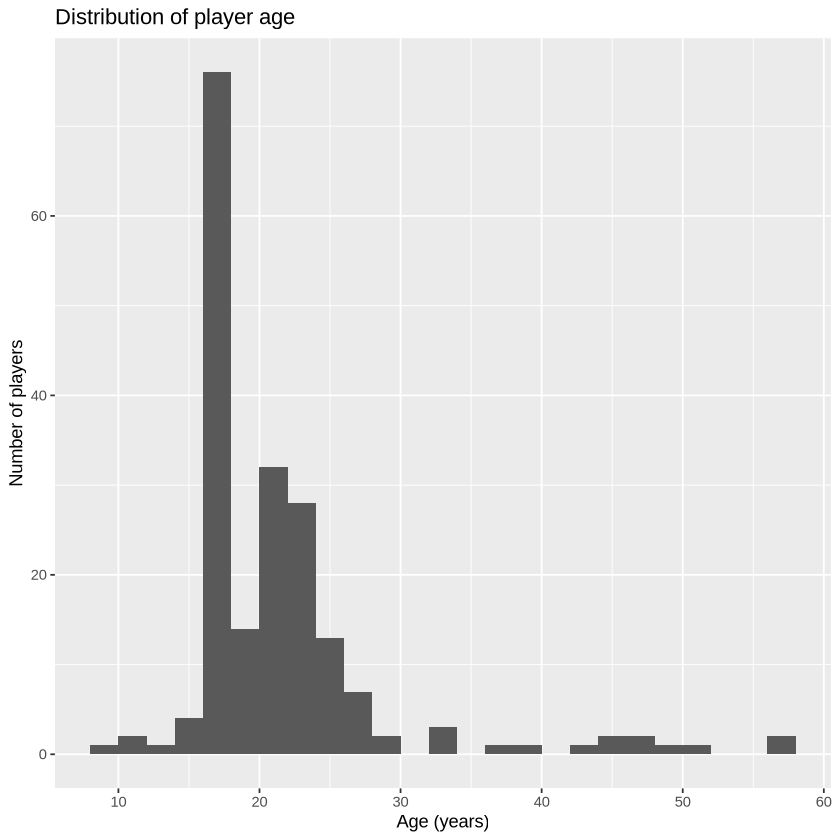

Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


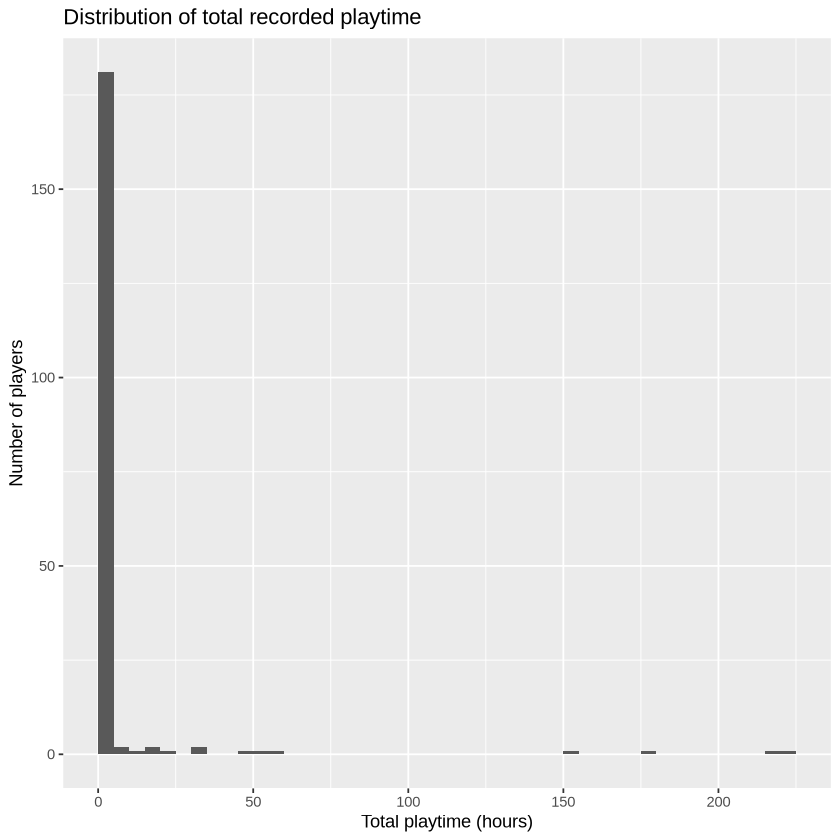

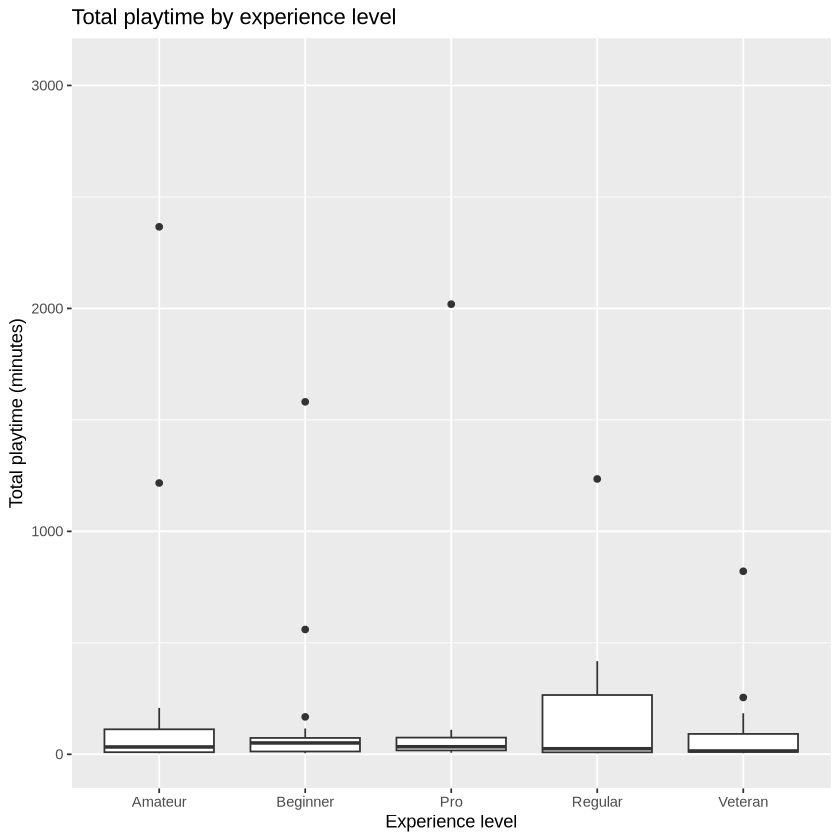

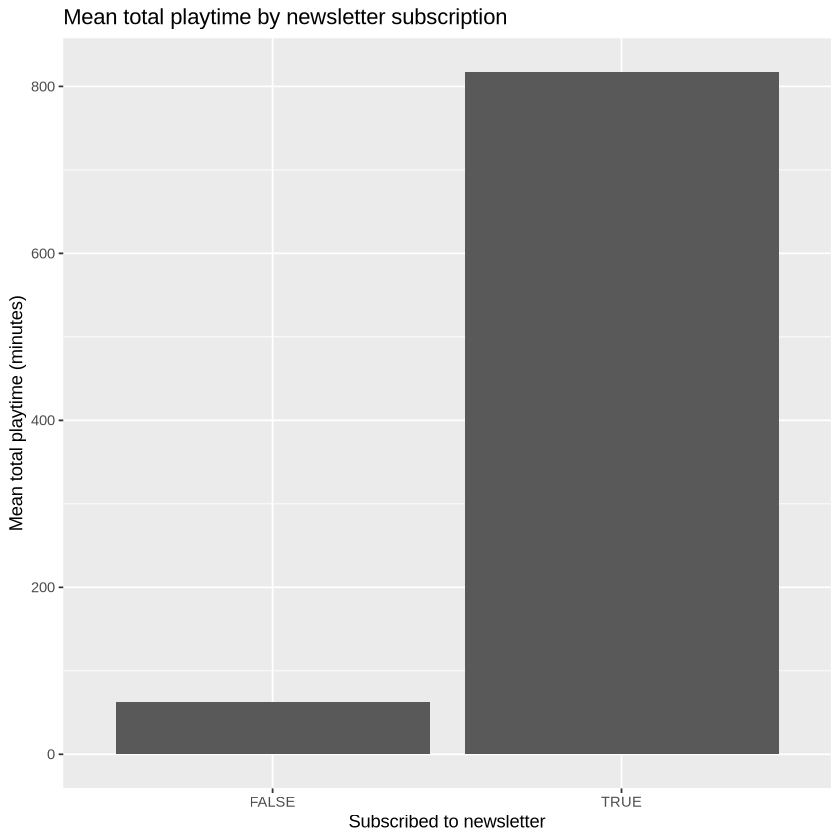

In [6]:

library(tidyverse)
library(lubridate)


players  <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

glimpse(players)
glimpse(sessions)

# wrangling
sessions_tidy <- sessions |>
  mutate(
    start_dt = dmy_hm(start_time),
    end_dt   = dmy_hm(end_time),
    session_minutes = as.numeric(difftime(end_dt, start_dt, units = "mins")))

# engagement summary
sessions_player <- sessions_tidy |>
  filter(!is.na(session_minutes)) |>
  group_by(hashedEmail) |>
  summarise( total_playtime_min = sum(session_minutes), avg_session_min    = mean(session_minutes), session_count      = n(), .groups = "drop")

#  join with players.csv to get one row per player
players_full <- players|>
  left_join(sessions_player, by = "hashedEmail")

# Means of quantitative variables in players.csv 
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "mean") |>
  mutate(mean = round(mean, 2))

players_means

# plotting

#  histogram of Age
ggplot(players, aes(x = Age)) +
  geom_histogram(binwidth = 2, boundary = 0, closed = "left") +
  labs( title = "Distribution of player age", x = "Age (years)", y = "Number of players" )

# Histogram of played_hours
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, boundary = 0, closed = "left") +
  labs( title = "Distribution of total recorded playtime", x = "Total playtime (hours)", y = "Number of players" )

# boxplot of total_playtime_min by experience
ggplot(players_full, aes(x = experience, y = total_playtime_min)) +
  geom_boxplot() +
  coord_cartesian(
    ylim = c( 0, quantile(players_full$total_playtime_min, 0.95, na.rm = TRUE) ) ) +
  labs(title = "Total playtime by experience level", x = "Experience level", y = "Total playtime (minutes)" )

# Bar chart of mean total_playtime_min by subscribe
players_full |>
  group_by(subscribe) |>
  summarise(
    mean_total_playtime_min = mean(total_playtime_min, na.rm = TRUE), .groups = "drop") |> 
ggplot(aes(x = subscribe, y = mean_total_playtime_min)) +
  geom_col() +
  labs( title = "Mean total playtime by newsletter subscription", x = "Subscribed to newsletter", y = "Mean total playtime (minutes)" )


### (3) insights from the plots

From the histograms above, we can clearly tell that most players are in their late teens or early twenties, and total playtime (in hours) is very skewed: a few players have much higher playtime than others.

The boxplot of `total_playtime_min` by `experience` suggests that more experienced players (for example, Regular, Veteran, Pro) tend to have higher total playtime, even though the data is spread inside each group. The bar chart of mean `total_playtime_min` by `subscribe` shows that newsletter subscribers on average play more than non-subscribers.

These patterns support our specific question: Can player engagement behaviours like total play time, average session length, and session frequency predict whether a player subscribes to the game-related newsletter?


### (4) Methods and plan

The outcome we are looking for is newsletter subscription (`subscribe`), which is TRUE/FALSE. That's why we plan to use **logistic regression**. The predictors will be:

- Engagement features: `total_playtime_min`, `avg_session_min`, `session_count`  
- Player information: `Age`, `gender`, `experience`  

Logistic regression is a great fit here because it is made for binary outcomes and gives us clear effects (how each variable changes the chance of subscribing). It is also a standard method we can explain easily.

We will assume that:

- Each player is independent  
- The relationship between predictors and the log odds of subscribing is not extremely non-linear  
- There are not too many tiny groups (for example, rare experience levels)

Some limitations are that logistic regression can struggle with strong outliers, very skewed predictors, or very complex patterns that are not even close to linear on the log-odds scale. Because total playtime is very skewed, we can put a log transformation or modify extreme values to reduce the effect of outliers.

For model selection, we plan to:

- Split the data once into 70% training and 30% test at the **player** level  
- On the training set, use k-fold cross-validation to compare a few models  
  (for example, a simple logistic model vs. a model with more interactions or a penalised version)  
- Choose the final model based on performance on the validation folds, then report its accuracy on the test set  
